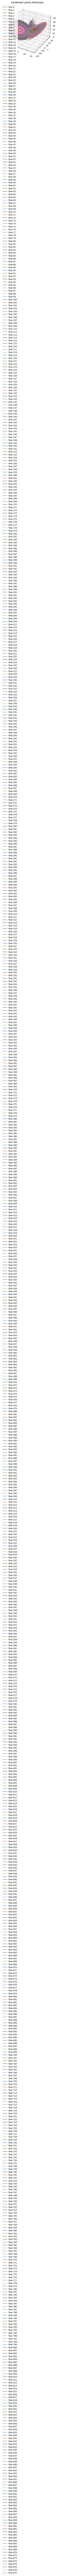

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import pandas as pd

def lorenz_equations(t, state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def apply_lorenz_equations(instance):
    columns = ['REB', 'AST', 'PTS']  # Using rebounds, assists, and points for Steph Curry
    initial_conditions = [instance[col] for col in columns]
    t_span = (0, 25)
    t_eval = np.linspace(*t_span, 1000)

    solution = solve_ivp(
        lorenz_equations,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval
    )

    return solution

dataset = pd.read_csv("E:\CHAOS\Stephen Curry Stats.csv")

# Plot combined Lorenz attractors for all rows in the dataset
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for index, row in dataset.iterrows():
    solution = apply_lorenz_equations(row)
    ax.plot(solution.y[0], solution.y[1], solution.y[2], label=f'Row {index}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Combined Lorenz Attractors')
ax.legend()
plt.show()


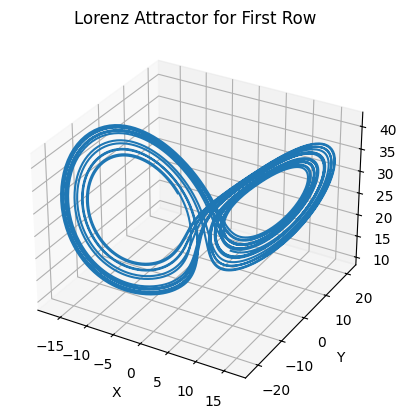

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import pandas as pd

def lorenz_equations(t, state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def apply_lorenz_equations(instance):
    columns = ['REB', 'AST', 'PTS']  # Using rebounds, assists, and points for Steph Curry
    initial_conditions = [instance[col] for col in columns]
    t_span = (0, 25)
    t_eval = np.linspace(*t_span, 5000)

    solution = solve_ivp(
        lorenz_equations,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval
    )

    return solution

dataset = pd.read_csv("E:\CHAOS\Stephen Curry Stats.csv")

# Take the first row from the dataset
first_row = dataset.iloc[0]

# Generate the trajectory for the first row
solution = apply_lorenz_equations(first_row)

# Store the subsequent states in X
X = solution.y.T[1:]  # Exclude the initial state

# Plot the Lorenz attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:, 0], X[:, 1], X[:, 2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor for First Row')
plt.show()


In [3]:
print(X)

[[ 2.24667912  7.11398829 13.88897694]
 [ 2.48736279  7.24569704 13.7893936 ]
 [ 2.72313985  7.39480655 13.70145813]
 ...
 [-4.87833856 -0.27498134 29.01286029]
 [-4.65322958 -0.25400487 28.63475527]
 [-4.4383169  -0.24256199 28.26100652]]


In [4]:
# Replace X_train, Y_train, and X with the values obtained previously


train_steps=2000
warm_steps=1000
test_steps=2000


In [5]:
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.hyper import research
import pandas as pd
import json
import numpy as np
# Load your dataset

# Define the objective function
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):

    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed
    
    losses = []
    r2s = []
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(units=500,
                              sr=sr,
                              lr=lr,
                              input_scaling=0.6,
                              seed=45,
                              input_connectivity=0.7,
                             )

        readout = Ridge(ridge=1e-7)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_val)

        loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_val, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}
# Define the hyperopt configuration
hyperopt_config = {
    "exp": "hyperopt-stephen-curry",
    "hp_max_evals": 200,
    "hp_method": "random",
    "seed": 0,
    "instances_per_trial": 3,
    "input_connectivity2":0,
    "hp_space": {
        "N": ["choice", 500],
        "sr": ["loguniform",1e-2, 10],
        "lr": ["loguniform", 1e-3, 1.0],
        "iss": ["choice", 0.9],
        "ridge": ["choice", 1e-7],
        "seed": ["choice", 45]
    }
}
import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [10]:
# Define the training set
X_train = X[:train_steps + warm_steps - 1]
Y_train = X[1:train_steps + warm_steps]
X_test = X[train_steps+warm_steps : -1]
y_test = X[train_steps+warm_steps + 1:]
# Run hyperparameter optimization using the research function
best_params = research(objective, ((X_train, Y_train), (X_test, y_test)), f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 611it [00:00, 6071.47it/s]           
Running Model-0: 1353it [00:00, 6841.72it/s]
Running Model-0: 2049it [00:00, 6878.90it/s]
Running Model-0: 2739it [00:00, 6865.61it/s]
Running Model-0: 2999it [00:00, 6839.62it/s]
Running Model-0: 100%|##########| 1/1 [00:00<00:00,  2.19it/s]


Fitting node Ridge-0...                                
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 644it [00:00, 6405.92it/s]           
Running Model-0: 1285it [00:00, 5501.19it/s]
Running Model-0: 1844it [00:00, 5301.28it/s]
Running Model-0: 1998it [00:00, 5363.52it/s]
Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1: 452it [00:00, 4498.88it/s]           
Running Model-1: 903it [00:00, 4488.91it/s]
Running Model-1: 1427it [00:00, 4818.65it/s]
Running Model-1: 2025it [00:00, 5260.69it/s]
Running Model-1: 2552it [00:00, 4882.83it/s]
Running Model-1: 2999it [00:00, 4747.96it/s]
Running Model-1: 100%|##########| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-1...                                
  0%|          | 0/200 [00:01<?, ?trial/s, best loss=?]

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1: 456it [00:00, 4553.11it/s]           
Running Model-1: 912it [00:00, 4543.31it/s]
Running Model-1: 1405it [00:00, 4707.65it/s]
Running Model-1: 1908it [00:00, 4827.15it/s]
Running Model-1: 1998it [00:00, 4727.71it/s]
Running Model-2:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-2: 287it [00:00, 2850.58it/s]           
Running Model-2: 600it [00:00, 3006.67it/s]
Running Model-2: 1000it [00:00, 3450.56it/s]
Running Model-2: 1428it [00:00, 3768.43it/s]
Running Model-2: 1861it [00:00, 3962.56it/s]
Running Model-2: 2273it [00:00, 4007.60it/s]
Running Model-2: 2690it [00:00, 4053.11it/s]
Running Model-2: 2999it [00:00, 3860.10it/s]
Running Model-2: 100%|##########| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-2...                                
  0%|          | 0/200 [00:03<?, ?trial/s, best loss=?]

Running Model-2:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-2: 353it [00:00, 3496.98it/s]           
Running Model-2: 753it [00:00, 3789.87it/s]
Running Model-2: 1159it [00:00, 3903.11it/s]
Running Model-2: 1550it [00:00, 3814.72it/s]
Running Model-2: 1932it [00:00, 3742.58it/s]
Running Model-2: 1998it [00:00, 3719.11it/s]


  0%|          | 1/200 [00:03<12:50,  3.87s/trial, best loss: 0.20385090542788573]

Running Model-3:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-3: 334it [00:00, 3327.16it/s]           
Running Model-3: 736it [00:00, 3721.39it/s]
Running Model-3: 1172it [00:00, 4002.42it/s]
Running Model-3: 1604it [00:00, 4118.73it/s]
Running Model-3: 2049it [00:00, 4236.39it/s]
Running Model-3: 2473it [00:00, 4165.63it/s]
Running Model-3: 2999it [00:00, 4261.25it/s]
Running Model-3: 100%|##########| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-3...                                                           
  0%|          | 1/200 [00:04<12:50,  3.87s/trial, best loss: 0.20385090542788573]

Running Model-3:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-3: 571it [00:00, 5679.04it/s]           
Running Model-3: 1139it [00:00, 5622.40it/s]
Running Model-3: 1735it [00:00, 5760.78it/s]
Running Model-3: 1998it [00:00, 5702.02it/s]
Running Model-4:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-4: 551it [00:00, 5482.01it/s]           
Running Model-4: 1100it [00:00, 5432.77it/s]
Running Model-4: 1644it [00:00, 5284.50it/s]
Running Model-4: 2229it [00:00, 5491.19it/s]
Running Model-4: 2779it [00:00, 5144.08it/s]
Running Model-4: 2999it [00:00, 5241.69it/s]
Running Model-4: 100%|##########| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-4...                                                           
  0%|          | 1/200 [00:05<12:50,  3.87s/trial, best loss: 0.20385090542788573]

Running Model-4:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-4: 499it [00:00, 4959.10it/s]           
Running Model-4: 995it [00:00, 3995.90it/s]
Running Model-4: 1446it [00:00, 4193.02it/s]
Running Model-4: 1979it [00:00, 4596.64it/s]
Running Model-4: 1998it [00:00, 4449.76it/s]
Running Model-5:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-5: 527it [00:00, 5241.59it/s]           
Running Model-5: 1095it [00:00, 5479.56it/s]
Running Model-5: 1643it [00:00, 5228.08it/s]
Running Model-5: 2168it [00:00, 5205.39it/s]
Running Model-5: 2690it [00:00, 4946.98it/s]
Running Model-5: 2999it [00:00, 4896.93it/s]
Running Model-5: 100%|##########| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-5...                                                           
  0%|          | 1/200 [00:07<12:50,  3.87s/trial, best loss: 0.20385090542788573]

Running Model-5:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-5: 475it [00:00, 4722.41it/s]           
Running Model-5: 948it [00:00, 4427.36it/s]
Running Model-5: 1392it [00:00, 4383.52it/s]
Running Model-5: 1878it [00:00, 4556.76it/s]
Running Model-5: 1998it [00:00, 4538.68it/s]


  1%|          | 2/200 [00:07<12:32,  3.80s/trial, best loss: 0.13689375653807184]

Running Model-6:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-6: 480it [00:00, 4773.29it/s]           
Running Model-6: 991it [00:00, 4954.70it/s]
Running Model-6: 1487it [00:00, 4709.57it/s]
Running Model-6: 1960it [00:00, 4654.14it/s]
Running Model-6: 2481it [00:00, 4846.92it/s]
Running Model-6: 2999it [00:00, 4896.31it/s]
Running Model-6: 100%|##########| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-6...                                                           
  1%|          | 2/200 [00:08<12:32,  3.80s/trial, best loss: 0.13689375653807184]

Running Model-6:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-6: 635it [00:00, 6295.01it/s]           
Running Model-6: 1358it [00:00, 6814.42it/s]
Running Model-6: 1998it [00:00, 6226.43it/s]
Running Model-7:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-7: 467it [00:00, 4656.40it/s]           
Running Model-7: 950it [00:00, 4742.36it/s]
Running Model-7: 1456it [00:00, 4874.57it/s]
Running Model-7: 2065it [00:00, 5339.93it/s]
Running Model-7: 2645it [00:00, 5493.89it/s]
Running Model-7: 2999it [00:00, 5352.46it/s]
Running Model-7: 100%|##########| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-7...                                                           
  1%|          | 2/200 [00:09<12:32,  3.80s/trial, best loss: 0.13689375653807184]

Running Model-7:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-7: 655it [00:00, 6516.15it/s]           
Running Model-7: 1307it [00:00, 6497.69it/s]
Running Model-7: 1957it [00:00, 6482.52it/s]
Running Model-7: 1998it [00:00, 6432.44it/s]
Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-8: 578it [00:00, 5749.81it/s]           
Running Model-8: 1153it [00:00, 5159.08it/s]
Running Model-8: 1809it [00:00, 5747.33it/s]
Running Model-8: 2390it [00:00, 5699.98it/s]
Running Model-8: 2964it [00:00, 4945.66it/s]
Running Model-8: 2999it [00:00, 5105.58it/s]
Running Model-8: 100%|##########| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-8...                                                           
  1%|          | 2/200 [00:10<12:32,  3.80s/trial, best loss: 0.13689375653807184]

Running Model-8:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-8: 494it [00:00, 4925.48it/s]           
Running Model-8: 1130it [00:00, 5751.19it/s]
Running Model-8: 1827it [00:00, 6289.88it/s]
Running Model-8: 1998it [00:00, 6081.31it/s]


  2%|▏         | 3/200 [00:10<11:42,  3.57s/trial, best loss: 0.015236859286339865]

Running Model-9:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-9: 500it [00:00, 4972.42it/s]           
Running Model-9: 1012it [00:00, 5042.17it/s]
Running Model-9: 1528it [00:00, 5083.89it/s]
Running Model-9: 2071it [00:00, 5206.63it/s]
Running Model-9: 2611it [00:00, 5267.14it/s]
Running Model-9: 2999it [00:00, 5304.62it/s]
Running Model-9: 100%|##########| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-9...                                                            
  2%|▏         | 3/200 [00:11<11:42,  3.57s/trial, best loss: 0.015236859286339865]

Running Model-9:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-9: 600it [00:00, 5987.33it/s]           
Running Model-9: 1199it [00:00, 5661.50it/s]
Running Model-9: 1767it [00:00, 5441.75it/s]
Running Model-9: 1998it [00:00, 5527.16it/s]
Running Model-10:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-10: 540it [00:00, 5365.80it/s]           
Running Model-10: 1116it [00:00, 5575.11it/s]
Running Model-10: 1674it [00:00, 5558.45it/s]
Running Model-10: 2234it [00:00, 5560.99it/s]
Running Model-10: 2809it [00:00, 5621.69it/s]
Running Model-10: 2999it [00:00, 5532.66it/s]
Running Model-10: 100%|##########| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-10...                                                           
  2%|▏         | 3/200 [00:12<11:42,  3.57s/trial, best loss: 0.015236859286339865]

Running Model-10:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-10: 531it [00:00, 5293.77it/s]           
Running Model-10: 1061it [00:00, 4918.54it/s]
Running Model-10: 1648it [00:00, 5312.09it/s]
Running Model-10: 1998it [00:00, 5293.87it/s]
Running Model-11:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-11: 620it [00:00, 6148.81it/s]           
Running Model-11: 1235it [00:00, 5487.27it/s]
Running Model-11: 1789it [00:00, 5293.27it/s]
Running Model-11: 2368it [00:00, 5463.80it/s]
Running Model-11: 2923it [00:00, 5483.64it/s]
Running Model-11: 2999it [00:00, 5480.99it/s]
Running Model-11: 100%|##########| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-11...                                                           
  2%|▏         | 3/200 [00:13<11:42,  3.57s/trial, best loss: 0.015236859286339865]

Running Model-11:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-11: 557it [00:00, 5541.70it/s]           
Running Model-11: 1147it [00:00, 5734.36it/s]
Running Model-11: 1789it [00:00, 6031.06it/s]
Running Model-11: 1998it [00:00, 5961.24it/s]


  2%|▏         | 4/200 [00:14<11:14,  3.44s/trial, best loss: 0.015236859286339865]

Running Model-12:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-12: 594it [00:00, 5906.87it/s]           
Running Model-12: 1185it [00:00, 5871.93it/s]
Running Model-12: 1976it [00:00, 6780.03it/s]
Running Model-12: 2672it [00:00, 6836.31it/s]
Running Model-12: 2999it [00:00, 6811.15it/s]
Running Model-12: 100%|##########| 1/1 [00:00<00:00,  2.17it/s]


Fitting node Ridge-12...                                                           
  2%|▏         | 4/200 [00:14<11:14,  3.44s/trial, best loss: 0.015236859286339865]

Running Model-12:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-12: 636it [00:00, 6310.73it/s]           
Running Model-12: 1332it [00:00, 6668.47it/s]
Running Model-12: 1998it [00:00, 6290.75it/s]
Running Model-13:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-13: 516it [00:00, 5149.48it/s]           
Running Model-13: 1031it [00:00, 4448.23it/s]
Running Model-13: 1580it [00:00, 4875.38it/s]
Running Model-13: 2263it [00:00, 5595.89it/s]
Running Model-13: 2831it [00:00, 5557.03it/s]
Running Model-13: 2999it [00:00, 5355.96it/s]
Running Model-13: 100%|##########| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-13...                                                           
  2%|▏         | 4/200 [00:15<11:14,  3.44s/trial, best loss: 0.015236859286339865]

Running Model-13:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-13: 675it [00:00, 6745.04it/s]           
Running Model-13: 1350it [00:00, 6316.90it/s]
Running Model-13: 1984it [00:00, 6230.43it/s]
Running Model-13: 1998it [00:00, 6239.45it/s]
Running Model-14:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-14: 581it [00:00, 5780.14it/s]           
Running Model-14: 1160it [00:00, 5666.95it/s]
Running Model-14: 1757it [00:00, 5788.99it/s]
Running Model-14: 2387it [00:00, 5975.49it/s]
Running Model-14: 2985it [00:00, 5920.20it/s]
Running Model-14: 2999it [00:00, 5836.52it/s]
Running Model-14: 100%|##########| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-14...                                                           
  2%|▏         | 4/200 [00:16<11:14,  3.44s/trial, best loss: 0.015236859286339865]

Running Model-14:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-14: 601it [00:00, 5977.81it/s]           
Running Model-14: 1199it [00:00, 5694.03it/s]
Running Model-14: 1868it [00:00, 6121.40it/s]
Running Model-14: 1998it [00:00, 6026.09it/s]


  2%|▎         | 5/200 [00:17<10:39,  3.28s/trial, best loss: 0.015236859286339865]

Running Model-15:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-15: 525it [00:00, 5222.34it/s]           
Running Model-15: 1048it [00:00, 5055.81it/s]
Running Model-15: 1554it [00:00, 4774.77it/s]
Running Model-15: 2069it [00:00, 4906.78it/s]
Running Model-15: 2623it [00:00, 5124.92it/s]
Running Model-15: 2999it [00:00, 5163.83it/s]
Running Model-15: 100%|##########| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-15...                                                           
  2%|▎         | 5/200 [00:17<10:39,  3.28s/trial, best loss: 0.015236859286339865]

Running Model-15:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-15: 726it [00:00, 7207.13it/s]           
Running Model-15: 1447it [00:00, 6891.67it/s]
Running Model-15: 1998it [00:00, 6886.12it/s]
Running Model-16:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-16: 682it [00:00, 6783.79it/s]           
Running Model-16: 1361it [00:00, 6726.76it/s]
Running Model-16: 1912it [00:00, 6547.11it/s]
Running Model-16:   0%|          | 0/1 [00:00<?, ?it/s]


  2%|▎         | 5/200 [00:18<12:02,  3.70s/trial, best loss: 0.015236859286339865]


KeyboardInterrupt: 

In [ ]:
print(best_params)

Running Model-0: 2999it [00:00, 8875.59it/s]<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Fitting node Ridge-0...
1999
Indices of NaN values in Y_pred: []
RMSE: 8.739981706091294
Shape of Y_pred: (1999, 3)
Min value of Y_pred: -23.59033039261785
Max value of Y_pred: 42.9675084831659
Shape of Y_test: (1999, 3)
Min value of Y_pred: -21.618818520756005
Max value of Y_pred: 42.04971587374362


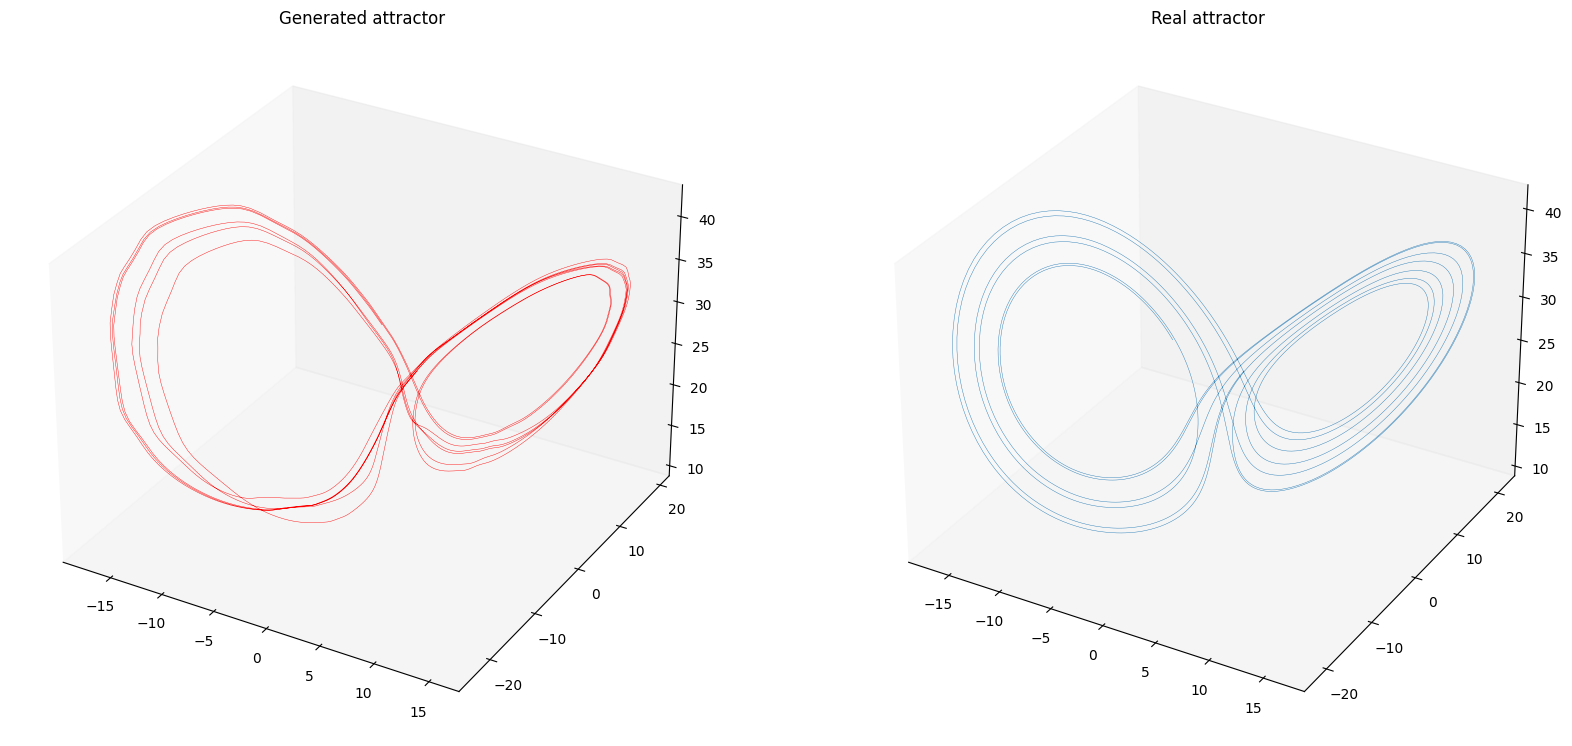

In [6]:
# Initialize reservoir and readout with the best parameters
reservoir = Reservoir(units=500, sr= 0.015354896275663277, lr=0.03542369395119896, input_scaling=0.6, seed=45,input_connectivity=0.7)
readout = Ridge(ridge=1e-7)

# Build the model with the best parameters
model = reservoir >> readout
X_train = X[:train_steps + warm_steps - 1]
Y_train = X[1:train_steps + warm_steps]
 # Assuming Y_test is the actual trajectory obtained previously

model = model.fit(X_train, Y_train)
# Now generate predictions using the trained model
u = X[train_steps + warm_steps]

Y_pred = np.zeros((test_steps-1, readout.output_dim))
for i in range(test_steps-1):
    Y_pred[i, :] = model(u)
    
    u = Y_pred[i, :]


Y_test = X[warm_steps+train_steps:]

print(len(Y_test))
from sklearn.metrics import mean_squared_error
nan_indices = np.argwhere(np.isnan(Y_pred))
print("Indices of NaN values in Y_pred:", nan_indices)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)
print("Shape of Y_pred:", Y_pred.shape)

# Check the range of values in Y_pred
print("Min value of Y_pred:", np.min(Y_pred))
print("Max value of Y_pred:", np.max(Y_pred))

# Check the shape of Y_test
print("Shape of Y_test:", Y_test.shape)
print("Min value of Y_pred:", np.min(Y_test))
print("Max value of Y_pred:", np.max(Y_test))
# Ensure that the plotting code is correctly configured

# Plot the generated attractor
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.grid(False)
ax.plot(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2], color='red', lw=.3)

# Plot the real attractor
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")
ax2.grid(False)
ax2.plot(Y_test[:, 0], Y_test[:, 1], Y_test[:, 2], lw=.3)

plt.show()